## Stable Differentiable Causal Discovery (SDCD) Tutorial

In this brief tutorial, we will go over the main API for the `sdcd` package. SDCD is a differentiable causal discovery method designed to scale reliably to hundreds and thousands of variables. The algorithm is implemented in vanilla PyTorch and also uses the `networkx` package. 

(Note, under the default pip installation, only the packages necessary to run the `SDCD` model are installed. If you would also like to run other causal discovery methods implemented in this package, you must also install the `benchmark` extra via the `pip install sdcd[benchmark]` command.)

In [1]:
# Imports
from sdcd.models import SDCD
from sdcd.utils import create_intervention_dataset

We will start by simulating some data for the tutorial. If you have your own data, you can ignore this step.

In [2]:
# Simulate Data
from sdcd.simulated_data import random_model_gaussian_global_variance # For demonstration

n = 200
n_per_intervention = 50
d = 20
n_edges = 20

true_causal_model = random_model_gaussian_global_variance(
    d,
    n_edges,
    dag_type="ER",
    scale=0.5,
    hard=True,
)
X_df = true_causal_model.generate_dataframe_from_all_distributions(
    n_samples_control=n,
    n_samples_per_intervention=n_per_intervention,
)
X_df.iloc[:, :-1] = (X_df.iloc[:, :-1] - X_df.iloc[:, :-1].mean()) / X_df.iloc[
    :, :-1
].std() # Normalize the data

The input data should be formatted as a Pandas Dataframe where each row corresponds to one observation and each column corresponds to one variable. There should be an additional column reports which variable(s) was intervened on for the given observation. Here it is labeled as `perturbation_label`. For rows that do not have any interventions, the value should be set to `"obs"`.

In [3]:
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,perturbation_label
0,-1.042648,0.226783,-1.871494,-1.581519,2.149227,-0.458693,0.714175,3.091564,-0.509956,0.036024,...,-1.486337,1.109146,1.863365,0.409856,0.858165,0.190376,0.407933,0.380345,0.605214,obs
1,-1.068825,0.559836,0.854967,0.205361,1.143803,0.896259,1.228846,-0.800072,-0.918887,-1.052896,...,-1.304848,1.779307,-0.951121,-0.049833,-0.104780,0.651097,0.105443,0.042832,0.458566,obs
2,-0.178734,-0.770220,0.989042,-0.676152,-0.534547,-0.174431,1.071692,-1.091981,-0.098621,0.191706,...,-0.111603,-0.645817,-1.211867,1.330255,-0.226251,0.530106,-0.267283,-0.685813,0.020803,obs
3,-0.359658,-1.081468,0.904916,0.500605,0.384816,-0.414948,-0.396487,-0.713363,-0.001175,-0.623004,...,-0.637798,-0.967510,-0.544244,-0.324714,0.335550,0.454699,-0.320341,-0.104311,0.478039,obs
4,0.906305,-0.653814,-1.006582,-0.506965,1.263883,-1.640321,-0.273144,0.785179,-0.078615,-1.359076,...,1.403845,-0.450875,0.264944,-0.603409,1.056394,-1.742338,0.175205,0.388329,-0.720161,obs


Now, to construct a torch dataset with the appropriate tensors, we use the utility function `sdcd.utils.create_intervention_dataset`.
 
(Note, we also have a function `sdcd.utils.create_dataset_anndata` for users working with the AnnData data format.)

In [4]:
X_dataset = create_intervention_dataset(X_df, perturbation_colname="perturbation_label")
X_dataset

Now, we are ready to train the SDCD model. Here, we will set `finetune=True` which runs the algorithm until the final adjacency matrix is estimated and binarized, then proceeds with a final stage of training the model until it converges for the fixed, discretized adjacency matrix. If you only care about the predicted graph, you may set this to `False` to shorten the runtime.

In [5]:
model = SDCD()
model.train(X_dataset, finetune=True)

Epoch 0: loss=27.26, gamma=0.00
Epoch 100: loss=9.29, gamma=0.00
Epoch 200: loss=7.22, gamma=0.00
Epoch 300: loss=6.15, gamma=0.00
Epoch 400: loss=5.41, gamma=0.00
Epoch 500: loss=4.80, gamma=0.00
Epoch 600: loss=4.41, gamma=0.00
Epoch 700: loss=4.04, gamma=0.00
Epoch 800: loss=3.75, gamma=0.00
Epoch 900: loss=3.45, gamma=0.00
Epoch 1000: loss=3.21, gamma=0.00
Epoch 1100: loss=2.93, gamma=0.00
Epoch 1200: loss=2.77, gamma=0.00
Epoch 1300: loss=2.61, gamma=0.00
Epoch 1400: loss=2.52, gamma=0.00
Epoch 1500: loss=2.46, gamma=0.00
Epoch 1600: loss=2.37, gamma=0.00
Epoch 1700: loss=2.29, gamma=0.00
Epoch 1800: loss=2.19, gamma=0.00
Epoch 1900: loss=2.09, gamma=0.00
Fraction of possible edges in mask: 0.1675
Epoch 0: loss=28.21, gamma=0.00
Epoch 100: loss=17.03, gamma=0.50
Epoch 200: loss=12.50, gamma=1.00
Epoch 300: loss=12.00, gamma=1.50
Epoch 400: loss=12.17, gamma=2.00
Epoch 500: loss=12.37, gamma=2.50
Epoch 600: loss=12.70, gamma=3.00
Epoch 700: loss=12.95, gamma=3.50
Epoch 800: loss=13

Lastly, we can recover the predicted adjacency matrix, both before thresholding and after thresholding, and compute likelihoods respect to a given observation.

In [6]:
adj_matrix = model.get_adjacency_matrix(threshold=True)
print(adj_matrix)

[[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]


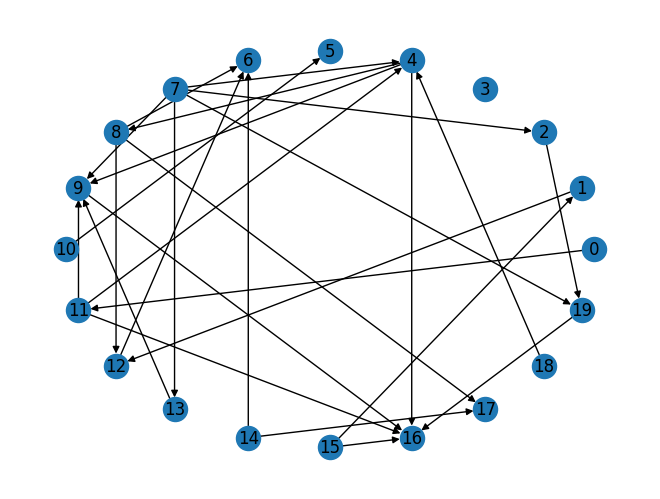

In [8]:
# We can visualize the graph with the networkx package (Note: you will need matplotlib for this step)
import networkx as nx
G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph())
nx.draw_circular(G, with_labels=True)

In [9]:
# To retrieve the unthresholded adjacency matrix
adj_matrix = model.get_adjacency_matrix(threshold=False)
print(adj_matrix)

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6727905e-03 0.0000000e+00
  0.0000000e+00 7.8354633e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3813855e-03
  0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9577078e-03 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.6522236e+00 0.0000000e+00 0.0000000e+00
  5.0185114e-01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.7044384e-03
  0.0000000e+00 0.0000000e+00 1.6327979e-03 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.3727842e-01]
 [0.0000000e+00 1.8689970e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0

In [ ]:
model.compute_nll(X_dataset) # Reports average negative log-likelihood

8.566566569010417

This concludes the tutorial. Please raise an issue on the Github repo if you come across any issues, and we hope you find this package useful to your research!